# ML Models for Fraud Classification

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score, roc_curve,auc,roc_auc_score, f1_score,precision_recall_curve,average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

##  Universal function that runs the classifier on:
1. Original data
2. SMOTE Oversampled Data
3. Ramdom Undersampled Data

In [2]:
def run_classifier(clf,Clasifier_name):
    sns.set_context(rc={'font.size': 16})
    ##Original Data
    clf.fit(data_features_train, data_labels_train.ravel())
    model_output_labels = clf.predict(data_features_test)
    model_output_prob = clf.predict_proba(data_features_test)[:,(1)]
    metrics = compute_metrics(model_output_prob,model_output_labels)
    results.append([Clasifier_name,"Imbalanced",metrics.values()])
    print('------------------------------------------Original Data*------------------------------------------')
    print_results(model_output_labels, metrics)
    draw_roc(metrics,Clasifier_name+' with unsampled data')
    

    ##SMOTE Oversampling
    clf.fit(x_train_smote, y_train_smote.ravel())
    model_output_labels = clf.predict(data_features_test)
    model_output_prob = clf.predict_proba(data_features_test)[:,(1)]
    metrics = compute_metrics(model_output_prob,model_output_labels)
    print('------------------------------------------SMOTE OverSampling*------------------------------------------')
    print_results(model_output_labels, metrics)
    draw_roc(metrics,Clasifier_name+' with SMOTE Oversampling')
    results.append([Clasifier_name,"SMOTE",metrics.values()])

    ##Random Undersampling
    clf.fit(x_train_rus, y_train_rus.ravel())
    model_output_labels = clf.predict(data_features_test)
    model_output_prob = clf.predict_proba(data_features_test)[:,(1)]
    metrics = compute_metrics(model_output_prob,model_output_labels)
    print('------------------------------------------Random UnderSampling*------------------------------------------')
    print_results(model_output_labels, metrics)
    draw_roc(metrics,Clasifier_name+' with Random Undersampling')
    results.append([Clasifier_name,"Random Undersampling",metrics.values()])

###  Function to print the Performance metric's of the classifier

In [3]:
def compute_metrics(model_output_prob,model_output_labels):
    metrics={}
    
    # Metrics for AUC Curve
    # Stores FPR,TPR scores for various thresholds
    FPR, TPR, _ = roc_curve(data_labels_test,model_output_prob,drop_intermediate=False) 
    metrics['ROC_AUC_Curve'] = [FPR,TPR]
    # Stores Precision/Recall scores for various thresholds
    
    Precision, Recall, _ = precision_recall_curve(data_labels_test,model_output_prob)
    metrics['PR_AUC_Curve'] = [Precision, Recall]
    
    # Metrics for evaluation
    metrics['ROC_AUC'] = '{:.3}'.format(roc_auc_score(data_labels_test,model_output_prob))
    metrics['PR_AUC'] = '{:.3}'.format(auc( Recall,Precision))
    metrics['PR_F1'] = '{:.3}'.format(f1_score(data_labels_test,model_output_labels))
    metrics['Precision_Score'] = '{:.3}'.format(precision_score(data_labels_test,model_output_labels))
    metrics['Recall_Score'] = '{:.3}'.format(recall_score(data_labels_test,model_output_labels))
    metrics['Confusion_Matrix'] = confusion_matrix(data_labels_test,model_output_labels)
        
    return metrics
    

In [4]:
def print_results(model_output_labels, metrics):
    sns.set_context(rc={'font.size': 16})
    
    print('Accuracy','{:.2%}'.format(clf.score(data_features_test, data_labels_test)),' *Inaccurate metric for imbalanced class')
    print('ROC AUC Score' , metrics['ROC_AUC'])
    print('PR AUC Score', metrics['PR_AUC'])
    print('PR F1 Score', metrics['PR_AUC'])
    print('Confusion Matrix')
    
    #Normalize the Matrix
    cm = metrics['Confusion_Matrix'].astype(int)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

    _=axes[0].imshow( cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].set_title("Confusion Matrix\n")

    _=axes[1].imshow( cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1].set_title("Normalized Confusion Matrix\n")

    for i,mat in enumerate([cm,cm_norm]):
        axes[i].xaxis.tick_top()
        axes[i].xaxis.set_label_position('top') 
        axes[i].set_xticks([0,1])
        axes[i].set_xticklabels( ['Authentic','Fraud'],fontsize=12)
        axes[i].set_yticks([0,1])
        axes[i].set_yticklabels( ['Authentic','Fraud'],fontsize=12)
        thresh = mat.max() / 2.
        for j,k in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            axes[i].text(k, j, format(mat[j,k], '0.2f' if i==1 else '0.0f'),
                     horizontalalignment="center",
                     color="white" if mat[j,k] > thresh else "black")

        axes[i].set_ylabel('True Class',fontsize=16)
        axes[i].set_xlabel('Predicted Class',fontsize=16)

### Function to draw ROC curve for the classifier

In [5]:
def draw_roc(metrics,title):
    plt.figure(figsize=(10,10))
    ##Adding the ROC
    sns.lineplot(metrics['ROC_AUC_Curve'][0],metrics['ROC_AUC_Curve'][1], lw=2, label="ROC AUC - "+metrics['ROC_AUC']).set_title('AUC curve for '+title)
    sns.lineplot(metrics['PR_AUC_Curve'][0],metrics['PR_AUC_Curve'][1], lw=2, label="PR AUC - "+metrics['PR_AUC'])
    
    ##Random FPR and TPR
    sns.lineplot([0, 1], [0, 1], lw=2,linestyle='--')
    
    ##Title and label
    plt.xlabel('FPR/Recall',fontsize=20)
    plt.ylabel('TPR/Precision',fontsize=20)
    plt.show()

### Loading data from file

In [6]:
data = pd.read_csv("creditcard.csv")

Sample record

In [7]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class distribuition  
0 - Authentic Transactions  
1 - Fraudulent Transactions

0    284315
1       492
Name: Class, dtype: int64


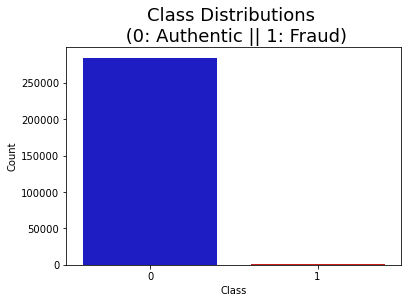

In [8]:
print(data.Class.value_counts())
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=data, palette=colors)
_=plt.title('Class Distributions \n (0: Authentic || 1: Fraud)', fontsize=18)
_=plt.ylabel('Count')

###### Standardizing the Amount variable

In [9]:
data["Normalized Amount"] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop(["Time","Amount"],axis=1,inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


# Using Random Forest Classifier to weigh feature importance

### Function to split the original data into Train and Test subsets

In [10]:
def UD_train_test_split(x): 
    x_features= x.loc[:,x.columns != "Class"]
    x_labels=x.loc[:,x.columns=="Class"]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    print("Records in Training data:",len(x_features_train))
    print("Records in Test data:",len(x_features_test))
    return(x_features_train,x_features_test,x_labels_train.values,x_labels_test.values)

### Train Test Split - (All Features Included)

In [11]:
data_features_train,data_features_test,data_labels_train,data_labels_test=UD_train_test_split(data) 

Records in Training data: 199364
Records in Test data: 85443


#### Creating SMOTE Oversampled train dataset

In [12]:
sm = SMOTE(random_state=12, sampling_strategy = 'minority')
x_train_smote, y_train_smote = sm.fit_sample(data_features_train, data_labels_train.ravel())

#### Creating Random Undersampled train dataset

In [13]:
results=[]
rus = RandomUnderSampler(random_state=12)
x_train_rus, y_train_rus = rus.fit_sample(data_features_train, data_labels_train.ravel())

------------------------------------------Original Data*------------------------------------------
Accuracy 99.96%  *Inaccurate metric for imbalanced class
ROC AUC Score 0.962
PR AUC Score 0.873
PR F1 Score 0.873
Confusion Matrix


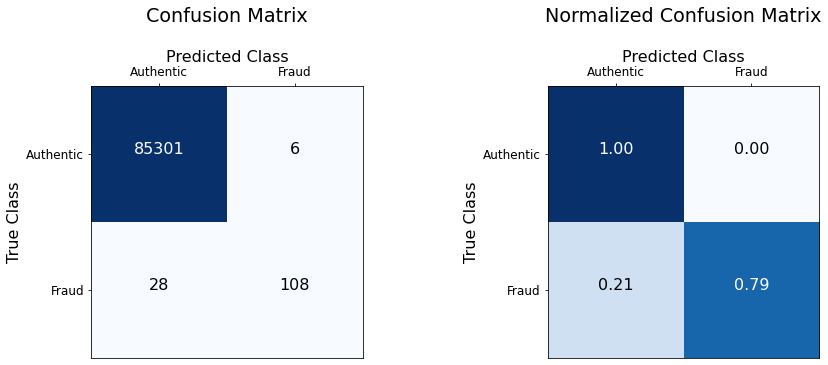

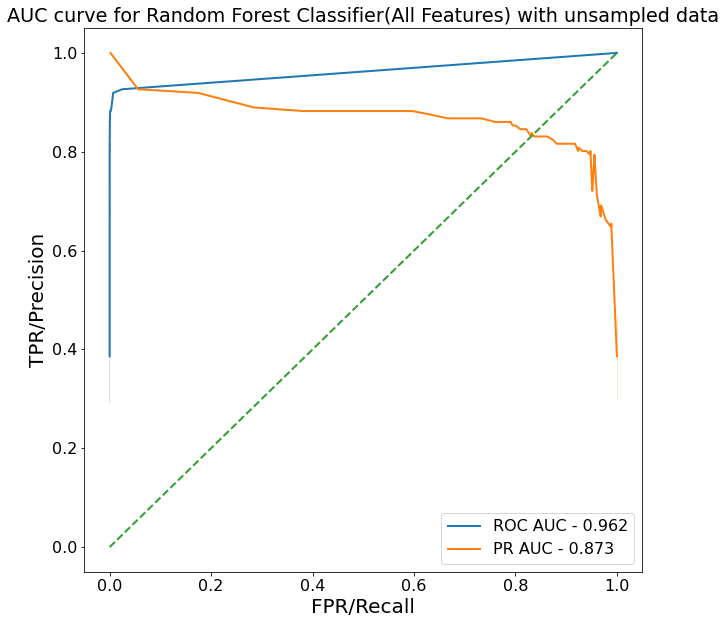

------------------------------------------SMOTE OverSampling*------------------------------------------
Accuracy 99.95%  *Inaccurate metric for imbalanced class
ROC AUC Score 0.984
PR AUC Score 0.87
PR F1 Score 0.87
Confusion Matrix


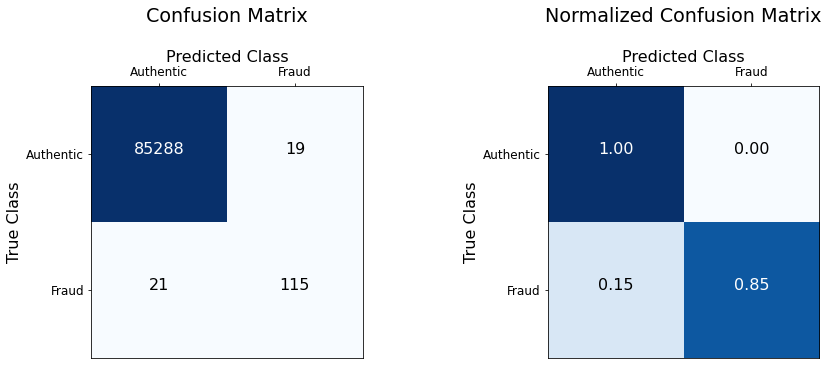

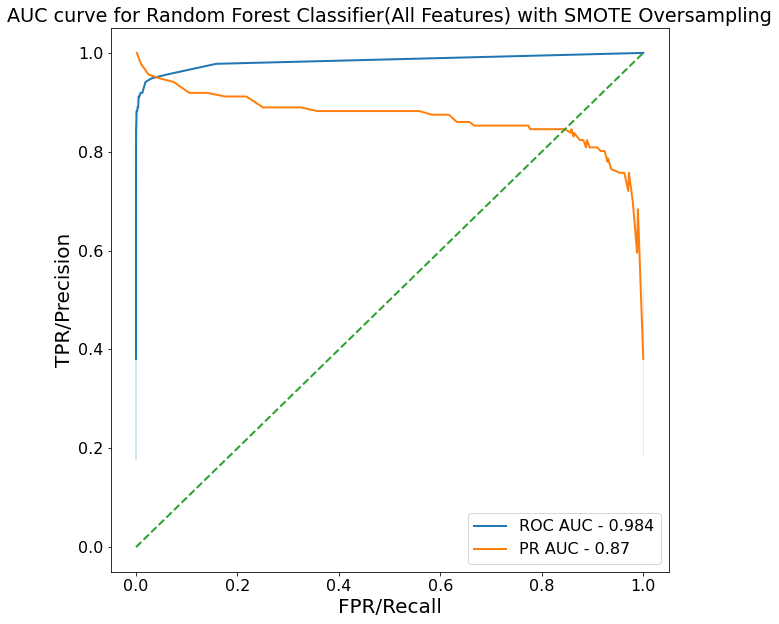

------------------------------------------Random UnderSampling*------------------------------------------
Accuracy 96.70%  *Inaccurate metric for imbalanced class
ROC AUC Score 0.987
PR AUC Score 0.77
PR F1 Score 0.77
Confusion Matrix


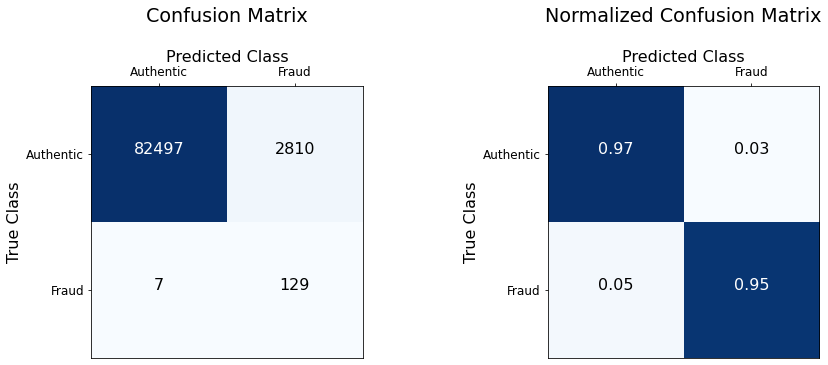

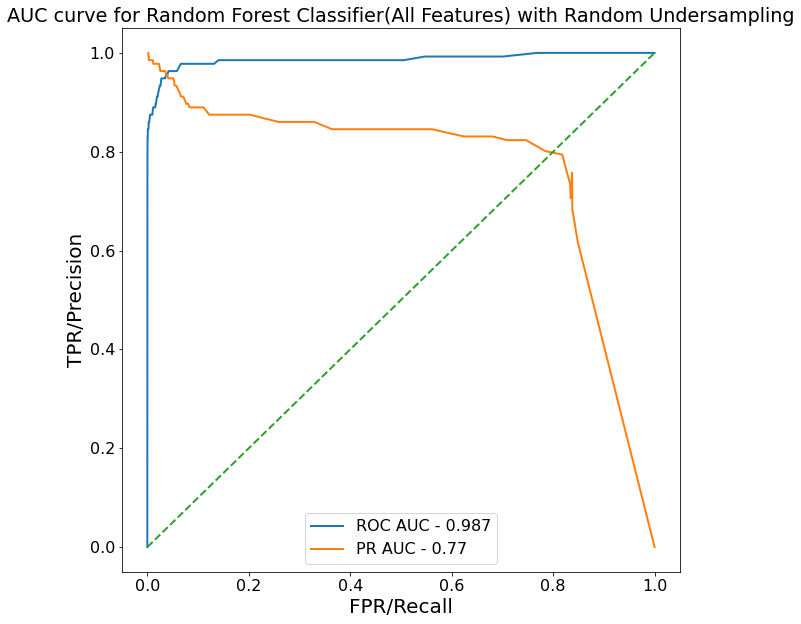

In [14]:
clf=RandomForestClassifier(n_estimators=100, random_state=12)
run_classifier(clf,"Random Forest Classifier(All Features)")

### Extracting feature importance

In [15]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = data_features_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

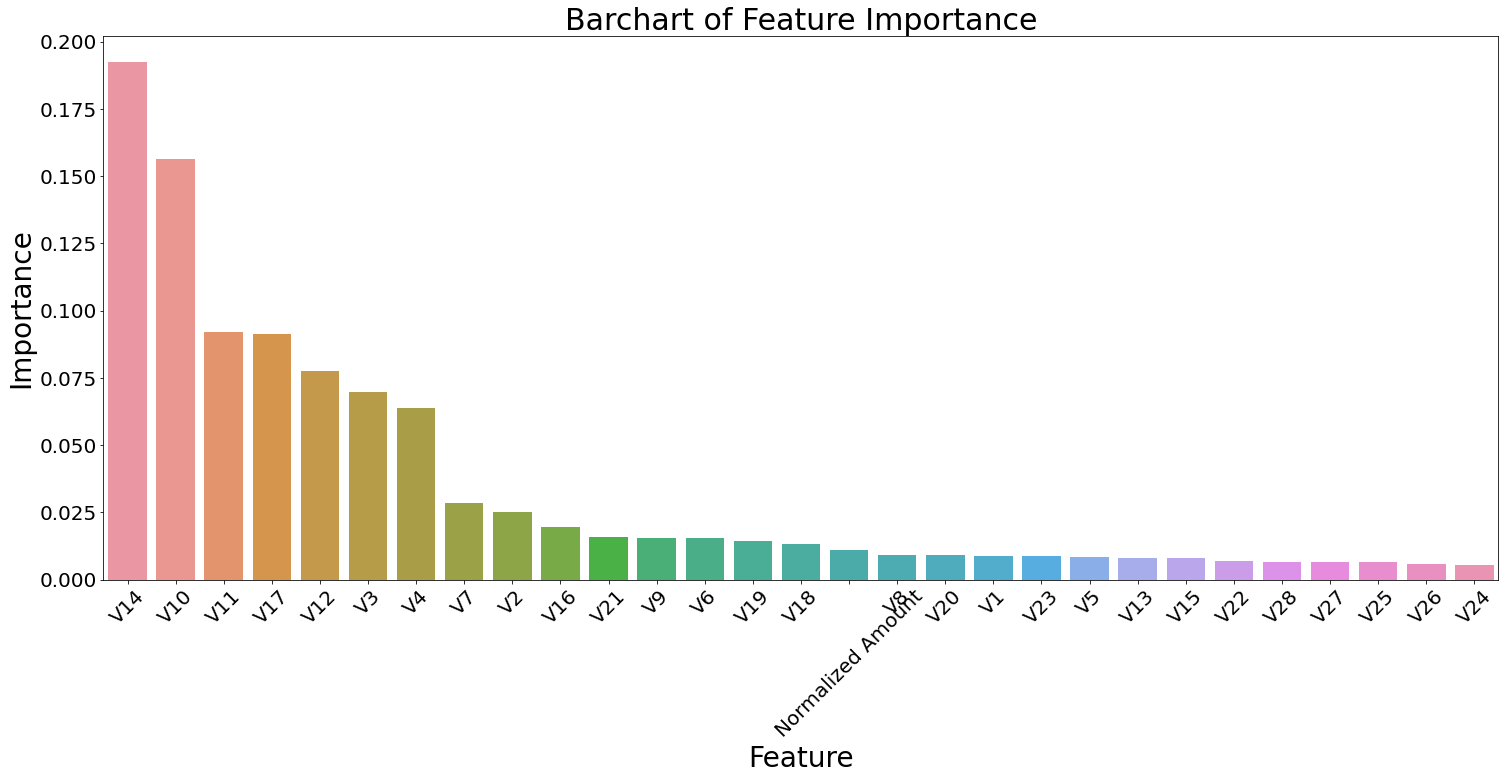

In [16]:
sns.set_context(rc={'font.size': 20})
plt.figure(figsize=(25,10))
sns.barplot(x=feature_importances.index,y=feature_importances.importance).set_title("Barchart of Feature Importance",fontsize=30)
plt.ylabel('Importance',fontsize=28)
plt.xlabel('Feature',fontsize=28)
_=plt.xticks(rotation=45)

## Logistic Regression - (All Features Included)

------------------------------------------Original Data*------------------------------------------
Accuracy 97.40%  *Inaccurate metric for imbalanced class
ROC AUC Score 0.985
PR AUC Score 0.759
PR F1 Score 0.759
Confusion Matrix


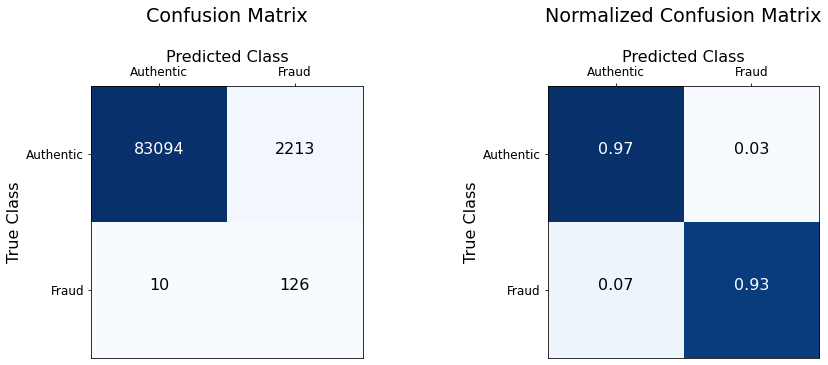

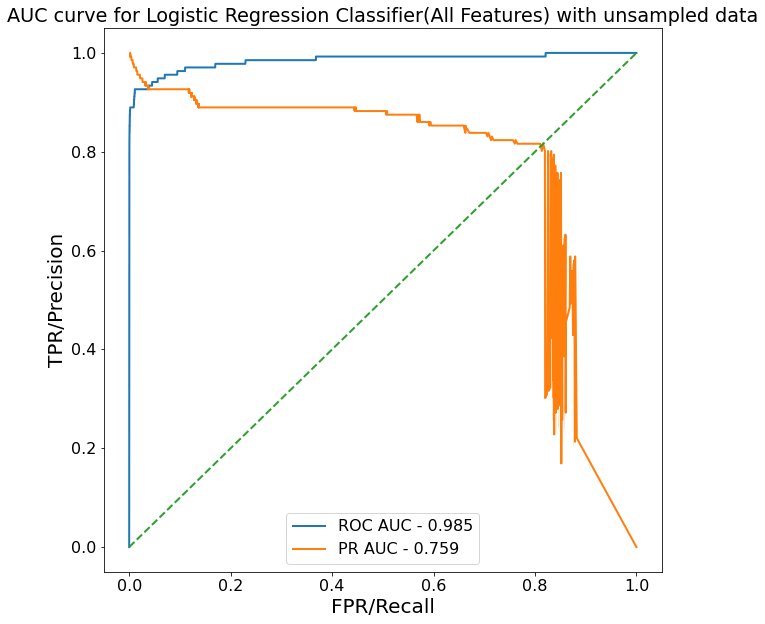

------------------------------------------SMOTE OverSampling*------------------------------------------
Accuracy 97.31%  *Inaccurate metric for imbalanced class
ROC AUC Score 0.982
PR AUC Score 0.759
PR F1 Score 0.759
Confusion Matrix


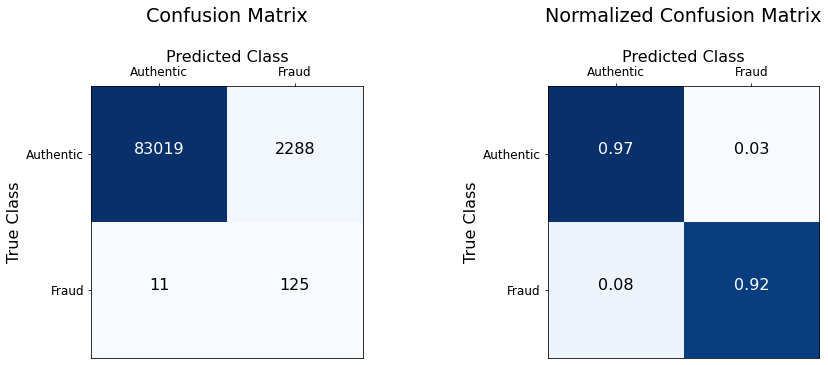

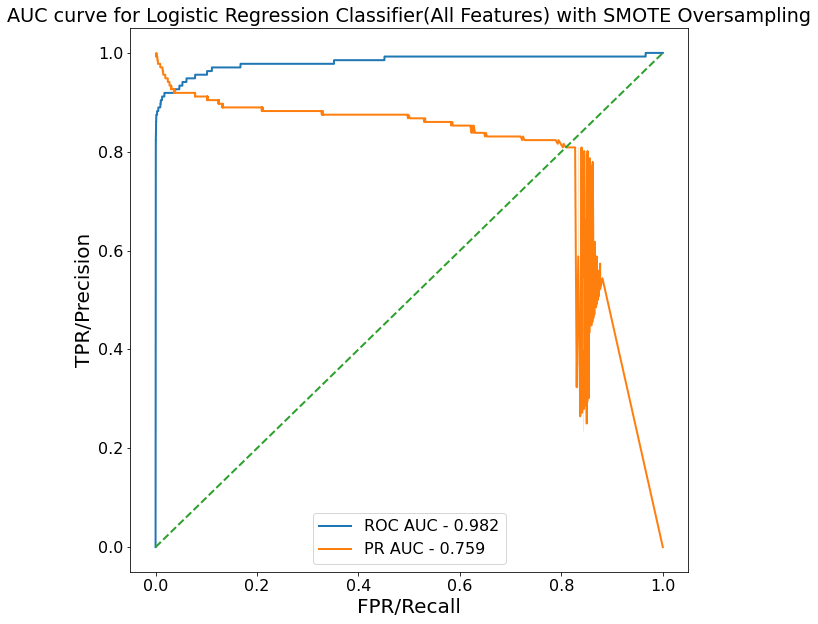

------------------------------------------Random UnderSampling*------------------------------------------
Accuracy 94.93%  *Inaccurate metric for imbalanced class
ROC AUC Score 0.986
PR AUC Score 0.742
PR F1 Score 0.742
Confusion Matrix


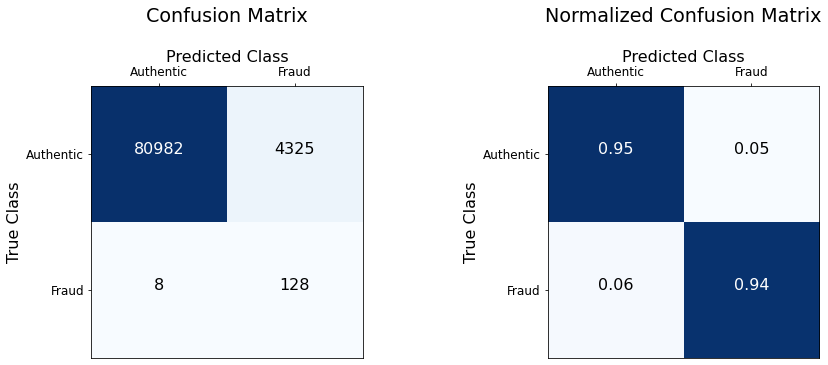

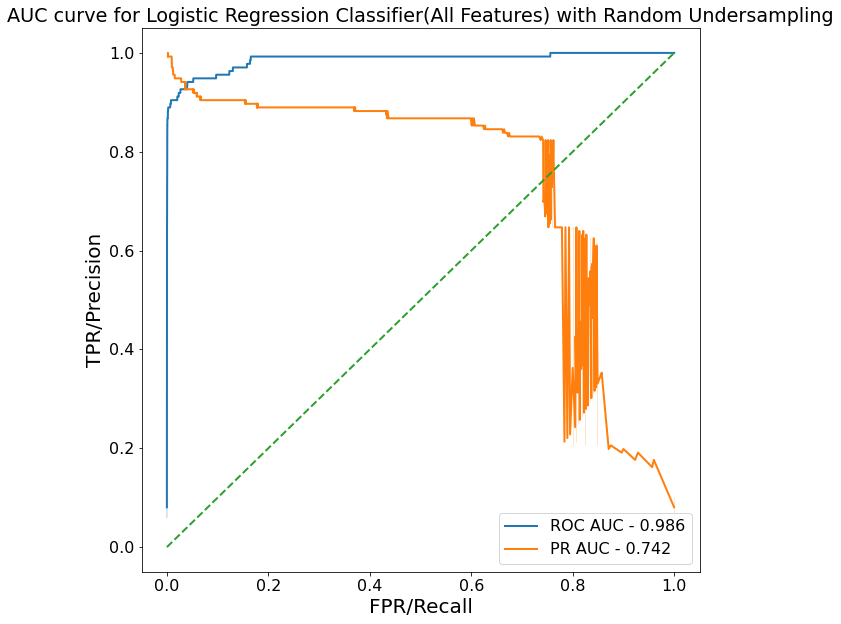

In [17]:
clf = LogisticRegression(class_weight='balanced', C = 0.01,penalty = 'l2',solver='liblinear')
run_classifier(clf,"Logistic Regression Classifier(All Features)")

## Dimension reduction to Top 5 features

In [18]:
#MOST RELAVANT FEATURES
data1=data[["V14","V10","V12","V17","V11","Class"]]
data1.head()

,V14,V10,V12,V17,V11,Class
0,-0.311169,0.090794,-0.617801,0.207971,-0.551600,0
1,-0.143772,-0.166974,1.065235,-0.114805,1.612727,0
2,-0.165946,0.207643,0.066084,1.109969,0.624501,0
3,-0.287924,-0.054952,0.178228,-0.684093,-0.226487,0
4,-1.119670,0.753074,0.538196,-0.237033,-0.822843,0


Oversampling only on the training data(Using SMOTE)

### Test Train Split - Top 5 features

In [19]:
data_features_train,data_features_test,data_labels_train,data_labels_test=UD_train_test_split(data1) 

Records in Training data: 199364
Records in Test data: 85443


#### Creating SMOTE Oversampled train dataset

In [21]:
sm = SMOTE(random_state=12, sampling_strategy = 'minority')
x_train_smote, y_train_smote = sm.fit_sample(data_features_train, data_labels_train.ravel())

#### Creating Random Undersampled train dataset

In [22]:
rus = RandomUnderSampler(random_state=12)
x_train_rus, y_train_rus = rus.fit_sample(data_features_train, data_labels_train.ravel())

## Ensemble methods for unbalanced classes - Random Forest classifier (gini)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=12,criterion='gini')
run_classifier(clf,"Random Forest Classifier(Top 5 Features)")

## Ensemble methods for unbalanced classes - Balanced bagging classifier

In [ ]:
clf = BalancedBaggingClassifier(random_state=12)
run_classifier(clf,"Balanced Bagging Classifier(Top 5 Features)")

## Ensemble methods for unbalanced classes - Logistic Regression classifier

In [ ]:
clf = LogisticRegression(class_weight='balanced', C = 0.01,penalty = 'l2',solver='liblinear')
run_classifier(clf,"Logistic Regression Classifier(Top 5 Features)")

## Ensemble methods for unbalanced classes - XG Boost classifier

In [ ]:
clf = GradientBoostingClassifier(learning_rate=0.15, n_estimators=100, min_samples_split=0.5, min_samples_leaf=45, max_depth=8,max_features ='sqrt',subsample =0.8)
run_classifier(clf,"XG Boost Classifier")

## Ensemble methods for unbalanced classes - Random Forest classifier (entropy)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=12,criterion='entropy')
run_classifier(clf,"Random Forest Classifier(Top 5 Features)")

In [ ]:
resultsdf = pd.DataFrame(results,columns=["Clasifier_name","Sampling_Method","FPR","TPR","Precision","Recall","ROC_AUC","PR_F1","PR_AUC"])
resultsdf

END OF NOTEBOOK